In [3]:
!pip install catboost

     |████████████████████████████████| 69.2MB 47kB/s 


In [115]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
#pd.set_option('max_colwidth', 500)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [116]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
vd = pd.read_csv('VariableDefinitions.csv')
vd

,ID,Person unique/random identification
0,country_code,The country codes
1,region,"Region_codes of a given country,.i.e., South A..."
2,age,Individual age
3,FQ1,Has ATM/debit card
4,FQ2,Is the ATM connected to an account with your n...
5,FQ3,Purchased with the ATM
6,FQ4,Has a credit card
7,FQ5,Used the credit card in 12 months
8,FQ6,Money deposits to a bank account in the last 1...
9,FQ7,Money withdrawals from a bank account in the l...


# **EDA**

Text(0.5, 1.0, 'Target Distribution')

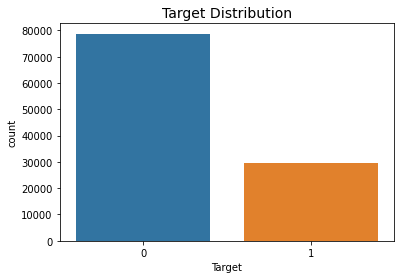

In [117]:
#It's an unbalanced competition!
sns.countplot(train.Target)
plt.title('Target Distribution', fontdict={'size':14})

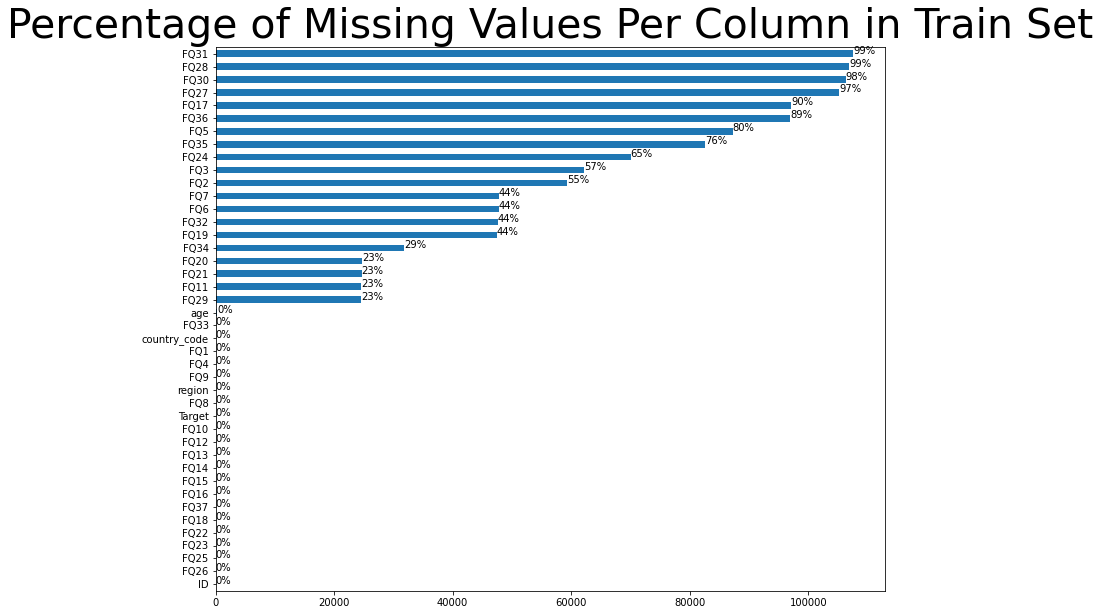

In [118]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (12, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':41})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

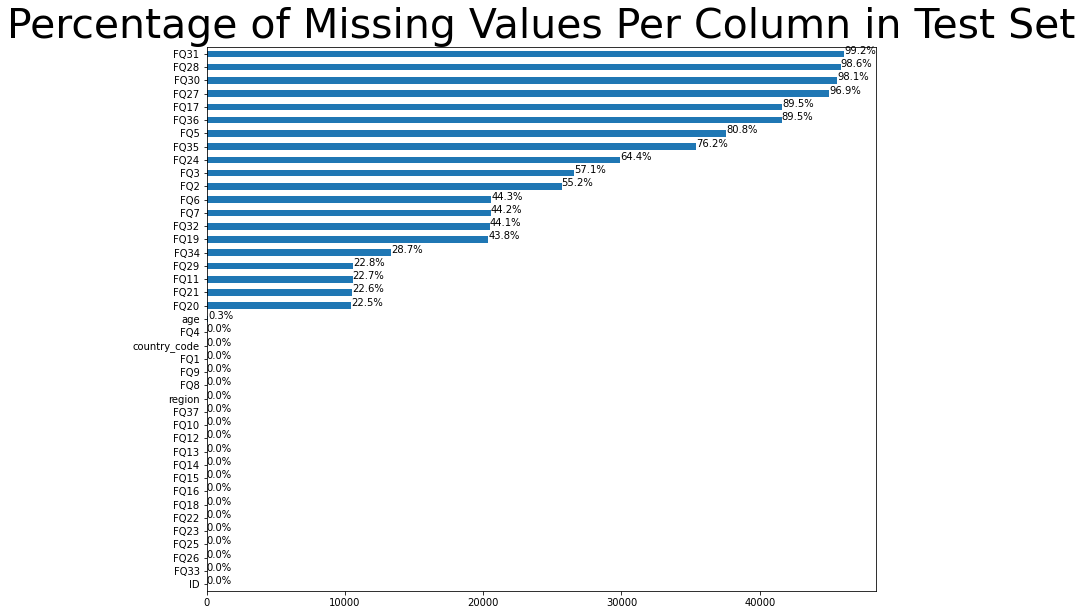

In [119]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (12, 10))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':41})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [120]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe


all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (154923, 42)


In [121]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154923 entries, 0 to 154922
Data columns (total 42 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            154923 non-null  object 
 1   country_code  154923 non-null  int64  
 2   region        154923 non-null  int64  
 3   age           154472 non-null  float64
 4   FQ1           154923 non-null  int64  
 5   FQ2           69925 non-null   float64
 6   FQ3           66146 non-null   float64
 7   FQ4           154923 non-null  int64  
 8   FQ5           30098 non-null   float64
 9   FQ6           86537 non-null   float64
 10  FQ7           86537 non-null   float64
 11  FQ8           154923 non-null  int64  
 12  FQ9           154923 non-null  int64  
 13  FQ10          154923 non-null  int64  
 14  FQ11          119788 non-null  float64
 15  FQ12          154923 non-null  int64  
 16  FQ13          154923 non-null  int64  
 17  FQ14          154923 non-null  int64  
 18  FQ15

# **Feature Engineering**

Split features to categorical and numerical features:

In [122]:
#Split features to categorical and numerical features
FQ_features = []
for i in range(1, 38):
    FQ_features.append("FQ" + str(i))
regional_features = ['country_code', 'region']
categorical_features = regional_features + FQ_features
numerical_features = ['age']

Handle missing FQ features:

In [123]:
#replace nan values by 3
all_data[FQ_features] = all_data[FQ_features].fillna(3)   


For FQ features, I merged the 3 values with the 4 values:  

In [124]:
for col in FQ_features:
    all_data.loc[all_data[col]==4, col] = 3

I changed the types of categorical features to 'category'

In [125]:
# before changing the type to 'category' I have to change it to int because it's not possible for float variables
for col in categorical_features:
    all_data[col] = all_data[col].astype('int')
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154923 entries, 0 to 154922
Data columns (total 42 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   ID            154923 non-null  object  
 1   country_code  154923 non-null  category
 2   region        154923 non-null  category
 3   age           154472 non-null  float64 
 4   FQ1           154923 non-null  category
 5   FQ2           154923 non-null  category
 6   FQ3           154923 non-null  category
 7   FQ4           154923 non-null  category
 8   FQ5           154923 non-null  category
 9   FQ6           154923 non-null  category
 10  FQ7           154923 non-null  category
 11  FQ8           154923 non-null  category
 12  FQ9           154923 non-null  category
 13  FQ10          154923 non-null  category
 14  FQ11          154923 non-null  category
 15  FQ12          154923 non-null  category
 16  FQ13          154923 non-null  category
 17  FQ14          154923 non-null

I replaced the nan values of age to the average values:

In [126]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
all_data['age'] = imp.fit_transform(all_data['age'].values.reshape(-1, 1))

I clustered the points to two clusters by the age

In [127]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(all_data[['age']])
all_data['Age clusters'] = kmeans.predict(all_data[['age']])


I created 3 new features: the number of FQ_features with 1 value, 2 values and 3 value 

In [128]:
all_data['sum_FQ_ones'] = 0
for col in FQ_features:
    df = all_data[all_data[col] == 1]
    df['sum_FQ_ones'] += 1
    all_data[all_data[col] == 1] = df

In [129]:
all_data['sum_FQ_twos'] = 0
for col in FQ_features:
    df = all_data[all_data[col] == 2]
    df['sum_FQ_twos'] += 1
    all_data[all_data[col] == 2] = df

In [130]:
all_data['sum_FQ_3'] = 0
for col in FQ_features:
    df = all_data[all_data[col] == 3]
    df['sum_FQ_3'] += 1
    all_data[all_data[col] == 3] = df

I created a new feature: the portion of FQ features of value 1 compared to the FQ features of values 1 and 2:

In [132]:
all_data['one_plus_two'] = all_data.sum_FQ_ones+all_data.sum_FQ_twos
all_data['fq1/one_plus_two'] = all_data[['sum_FQ_ones']].div(all_data.one_plus_two, axis=0)


Treatment of outliers:

In [133]:
def winsorize(df, variable, upper_limit, lower_limit):
  return np.where(df[variable] > upper_limit, upper_limit,
  np.where(df[variable] < lower_limit, lower_limit,
  df[variable]))

In [134]:
all_data['age'] = winsorize(all_data, 'age', 100, 0) 

Mean encoding of region:

In [135]:
cumsum = all_data.groupby('region')['Target'].cumsum() - all_data['Target']
cumcnt = all_data.groupby('region').cumcount()

all_data['region_enc'] = cumsum / cumcnt
all_data['region_enc'].fillna(0.3343, inplace=True) 
encoded_feature = all_data['region_enc'].values



Mean encoding of country_code:

In [136]:
cumsum = all_data.groupby('country_code')['Target'].cumsum() - all_data['Target']
cumcnt = all_data.groupby('country_code').cumcount()

all_data['country_code_enc'] = cumsum / cumcnt
all_data['country_code_enc'].fillna(0.3343, inplace=True) 
encoded_feature = all_data['country_code_enc'].values



Separate train and test data from the combined dataframe:

In [137]:
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]
target = train_df.Target.astype(int)
train_df.drop('ID', axis=1, inplace=True)
train_df.drop('Target', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)
test_df.drop('Target', axis=1, inplace=True)

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((108446, 48), (46477, 48))

In [138]:
#cross validation
n_skf=5
kf=StratifiedKFold(n_skf, random_state=42)
seed=42


Over Sampling the training data of the minority class:

In [139]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(train_df, target)

print(X_ros.shape[0] - train_df.shape[0], 'new random picked points')
#plot_2d_space(X_ros, y_ros, 'Random over-sampling')

49024 new random picked points


In [140]:
#The index of categorical variables:
categorical_features_indices = list(range(0, 40))
categorical_features_indices.pop(2)


2

In [143]:
#transform the data from array to dataframe
X = pd.DataFrame(X_ros)
y = pd.DataFrame(y_ros)
X.columns = train_df.columns
# Change each column to its appriopriate datatype
for col in categorical_features:
    X[col] = X[col].astype('int')
    X[col] = X[col].astype('category')



# **Modeling**

Catboost model:

In [144]:
score_list = []
score = 0
test_oofs1 = []


#multiple iterations with stratified kfold
for i, (tr_idx, vr_idx) in enumerate(kf.split(X, y)):
    X_train, y_train = X.loc[tr_idx, :], y.loc[tr_idx]
    xval, yval = X.loc[vr_idx, :], y.loc[vr_idx]
    params = {
    'loss_function': 'Logloss',
    'eval_metric':'AUC', # metric,
    'depth': 9,
    'iterations': 1428,
    'learning_rate': 0.07888843022725764,
    'cat_features' : categorical_features_indices,
    'verbose': 200, # output to stdout info about training process every 200 iterations
    'random_seed': 42,
    'task_type': "GPU"
    }   

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
      eval_set=(xval,yval), # data to validate on
      use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
      plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
     );
  
    #model prediction
    p = model.predict_proba(xval)[:,1]
    sc = roc_auc_score(yval, p)
    score_list.append(sc)
    score += sc/n_skf

    #prediction on test data
    pred=model.predict_proba(test_df)[:,1]

    #append last prediction to the test_oof empty list
    test_oofs1.append(pred)

    print('Fold {} : {}'.format(i, sc))

print()
print()
print('Avg log :',sc)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5699283	test: 0.4910845	best: 0.4910845 (0)	total: 146ms	remaining: 3m 28s
200:	learn: 0.8492570	test: 0.5496112	best: 0.5496112 (200)	total: 19s	remaining: 1m 55s
400:	learn: 0.8853943	test: 0.5984334	best: 0.5984334 (400)	total: 37.7s	remaining: 1m 36s
600:	learn: 0.9042965	test: 0.6060459	best: 0.6086768 (569)	total: 56.3s	remaining: 1m 17s
800:	learn: 0.9195226	test: 0.6069569	best: 0.6086768 (569)	total: 1m 14s	remaining: 58.6s
1000:	learn: 0.9323664	test: 0.6150076	best: 0.6150076 (1000)	total: 1m 34s	remaining: 40.1s
1200:	learn: 0.9417388	test: 0.6191368	best: 0.6196541 (1199)	total: 1m 53s	remaining: 21.4s
1400:	learn: 0.9496765	test: 0.6172569	best: 0.6196541 (1199)	total: 2m 12s	remaining: 2.55s
1427:	learn: 0.9505854	test: 0.6175764	best: 0.6196541 (1199)	total: 2m 14s	remaining: 0us
bestTest = 0.619654119
bestIteration = 1199
Shrink model to first 1200 iterations.
Fold 0 : 0.6196541586943176


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6020198	test: 0.3869422	best: 0.3869422 (0)	total: 147ms	remaining: 3m 29s
200:	learn: 0.8430501	test: 0.5751049	best: 0.5751049 (200)	total: 18.9s	remaining: 1m 55s
400:	learn: 0.8815739	test: 0.6730047	best: 0.6730047 (400)	total: 37.4s	remaining: 1m 35s
600:	learn: 0.9022260	test: 0.7037282	best: 0.7051132 (568)	total: 55.9s	remaining: 1m 16s
800:	learn: 0.9168158	test: 0.7207224	best: 0.7207224 (800)	total: 1m 14s	remaining: 58.2s
1000:	learn: 0.9283590	test: 0.7330379	best: 0.7330379 (1000)	total: 1m 33s	remaining: 39.7s
1200:	learn: 0.9376581	test: 0.7400884	best: 0.7401717 (1195)	total: 1m 51s	remaining: 21.2s
1400:	learn: 0.9454651	test: 0.7458770	best: 0.7458770 (1400)	total: 2m 11s	remaining: 2.52s
1427:	learn: 0.9466323	test: 0.7464551	best: 0.7464551 (1427)	total: 2m 13s	remaining: 0us
bestTest = 0.746455133
bestIteration = 1427
Fold 1 : 0.7464551687391255


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5759894	test: 0.5620257	best: 0.5620257 (0)	total: 156ms	remaining: 3m 42s
200:	learn: 0.8230241	test: 0.8824789	best: 0.8824789 (200)	total: 18.7s	remaining: 1m 54s
400:	learn: 0.8628399	test: 0.9166167	best: 0.9166167 (400)	total: 37s	remaining: 1m 34s
600:	learn: 0.8864033	test: 0.9249493	best: 0.9249493 (600)	total: 55.3s	remaining: 1m 16s
800:	learn: 0.9032674	test: 0.9323369	best: 0.9323369 (800)	total: 1m 13s	remaining: 57.9s
1000:	learn: 0.9169063	test: 0.9356926	best: 0.9361280 (984)	total: 1m 32s	remaining: 39.5s
1200:	learn: 0.9290755	test: 0.9370936	best: 0.9379233 (1194)	total: 1m 51s	remaining: 21.1s
1400:	learn: 0.9380231	test: 0.9406959	best: 0.9406959 (1400)	total: 2m 10s	remaining: 2.52s
1427:	learn: 0.9392937	test: 0.9411704	best: 0.9412381 (1424)	total: 2m 13s	remaining: 0us
bestTest = 0.9412381053
bestIteration = 1424
Shrink model to first 1425 iterations.
Fold 2 : 0.9412381296330852


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5728177	test: 0.5352853	best: 0.5352853 (0)	total: 154ms	remaining: 3m 39s
200:	learn: 0.8229963	test: 0.8559180	best: 0.8559180 (200)	total: 18.8s	remaining: 1m 54s
400:	learn: 0.8621351	test: 0.8990175	best: 0.8990175 (400)	total: 37.4s	remaining: 1m 35s
600:	learn: 0.8846242	test: 0.9129215	best: 0.9130216 (599)	total: 55.5s	remaining: 1m 16s
800:	learn: 0.9031191	test: 0.9163885	best: 0.9179397 (784)	total: 1m 14s	remaining: 58s
1000:	learn: 0.9167527	test: 0.9168614	best: 0.9205348 (980)	total: 1m 32s	remaining: 39.6s
1200:	learn: 0.9288116	test: 0.9205664	best: 0.9205671 (1199)	total: 1m 51s	remaining: 21.1s
1400:	learn: 0.9386208	test: 0.9215133	best: 0.9218265 (1366)	total: 2m 10s	remaining: 2.52s
1427:	learn: 0.9399607	test: 0.9222549	best: 0.9222549 (1427)	total: 2m 13s	remaining: 0us
bestTest = 0.9222548604
bestIteration = 1427
Fold 3 : 0.9222548784508732


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5842730	test: 0.4663745	best: 0.4663745 (0)	total: 149ms	remaining: 3m 32s
200:	learn: 0.8212625	test: 0.7950006	best: 0.7950006 (200)	total: 18.6s	remaining: 1m 53s
400:	learn: 0.8614120	test: 0.8519033	best: 0.8519033 (400)	total: 37s	remaining: 1m 34s
600:	learn: 0.8852901	test: 0.8712837	best: 0.8712837 (600)	total: 55.4s	remaining: 1m 16s
800:	learn: 0.9032367	test: 0.8854427	best: 0.8868918 (786)	total: 1m 14s	remaining: 57.9s
1000:	learn: 0.9179810	test: 0.8929508	best: 0.8929508 (1000)	total: 1m 32s	remaining: 39.6s
1200:	learn: 0.9305623	test: 0.8973081	best: 0.8973081 (1200)	total: 1m 51s	remaining: 21.1s
1400:	learn: 0.9398689	test: 0.8987643	best: 0.9002884 (1368)	total: 2m 10s	remaining: 2.52s
1427:	learn: 0.9411277	test: 0.8979297	best: 0.9002884 (1368)	total: 2m 13s	remaining: 0us
bestTest = 0.900288403
bestIteration = 1368
Shrink model to first 1369 iterations.
Fold 4 : 0.9002884158335118


Avg log : 0.9002884158335118


In [146]:
score_list = []
score = 0
test_oofs2 = []

#multiple iterations with stratified kfold
for i, (tr_idx, vr_idx) in enumerate(kf.split(X,y)):
    X_train, y_train = X.loc[tr_idx, :], y.loc[tr_idx]
    xval, yval = X.loc[vr_idx, :], y.loc[vr_idx]
    params = {
        'n_estimators': 1400,
        'learning_rate': 0.07888843022725764,
        'max_depth': 9,
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(xval,yval)],eval_metric='AUC')
    
    #model prediction
    p = model.predict_proba(xval)[:, 1]
    sc = roc_auc_score(yval, p)
    score_list.append(sc)
    score += sc/n_skf
    
    #prediction on test data
    pred=model.predict_proba(test_df[:])[:,1]

    #append last prediction to the test_oof empty list
    test_oofs2.append(pred)
    
    print('Fold {} : {}'.format(i, sc))
    
print()
print()
print('Avg log :',score)

Streaming output truncated to the last 5000 lines.
[608]	valid_0's auc: 0.14414
[609]	valid_0's auc: 0.144329
[610]	valid_0's auc: 0.144519
[611]	valid_0's auc: 0.144606
[612]	valid_0's auc: 0.144727
[613]	valid_0's auc: 0.144967
[614]	valid_0's auc: 0.144989
[615]	valid_0's auc: 0.145066
[616]	valid_0's auc: 0.145254
[617]	valid_0's auc: 0.145252
[618]	valid_0's auc: 0.14537
[619]	valid_0's auc: 0.145565
[620]	valid_0's auc: 0.145578
[621]	valid_0's auc: 0.145777
[622]	valid_0's auc: 0.145796
[623]	valid_0's auc: 0.146037
[624]	valid_0's auc: 0.146113
[625]	valid_0's auc: 0.146331
[626]	valid_0's auc: 0.146601
[627]	valid_0's auc: 0.146847
[628]	valid_0's auc: 0.147055
[629]	valid_0's auc: 0.147064
[630]	valid_0's auc: 0.147085
[631]	valid_0's auc: 0.147346
[632]	valid_0's auc: 0.147607
[633]	valid_0's auc: 0.14765
[634]	valid_0's auc: 0.147769
[635]	valid_0's auc: 0.147908
[636]	valid_0's auc: 0.148079
[637]	valid_0's auc: 0.148087
[638]	valid_0's auc: 0.148171
[639]	valid_0's auc: 0

Model averaging:

In [147]:
predictions = (0.70*np.mean(test_oofs1, axis=0) + 0.30*np.mean(test_oofs2, axis=0))

Make submission:

In [148]:
submission_df = pd.DataFrame()
submission_df["ID"] = test["ID"]

In [149]:
submission_df["Target"] = predictions
submission_df.to_csv("sub.csv", index=False)